In [1]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [3]:
datafile = '../data/mnist.json.gz'
print('loading mnist dataset from {} ......'.format(datafile))
# 加载json数据文件
data = json.load(gzip.open(datafile))
print('mnist dataset load done')
# 读取到的数据区分训练集，验证集，测试集
train_set, val_set, eval_set = data

# 观察训练集数据
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs))

# 观察验证集数量
imgs, labels = val_set[0], val_set[1]
print("验证数据集数量: ", len(imgs))

# 观察测试集数量
imgs, labels = val= eval_set[0], eval_set[1]
print("测试数据集数量: ", len(imgs))

loading mnist dataset from ../data/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
验证数据集数量:  10000
测试数据集数量:  10000


In [6]:
def load_data(mode='train'):
    datafile = '../data/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
   
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    
    # 获得数据集长度
    imgs_length = len(imgs)
    
    # 定义数据集每个数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            # 训练模式下打乱数据
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据处理成希望的类型
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
    
        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [9]:
#数据处理部分之后的代码，数据读取的部分调用Load_data函数
# 定义网络结构，同上一节所使用的网络结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)

    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

# 训练配置，并启动训练过程
def train(model):
    model = MNIST()
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train')
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels) 

            #前向计算的过程
            predits = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predits, labels)
            avg_loss = paddle.mean(loss)      
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    # 保存模型
    paddle.save(model.state_dict(), './mnist.pdparams')
# 创建模型           
model = MNIST()
# 启动训练过程
train(model)

loading mnist dataset from ../data/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
epoch: 0, batch: 0, loss is: [26.9831]
epoch: 0, batch: 200, loss is: [9.439035]
epoch: 0, batch: 400, loss is: [7.651777]
epoch: 1, batch: 0, loss is: [9.141344]
epoch: 1, batch: 200, loss is: [7.6869717]
epoch: 1, batch: 400, loss is: [7.7852345]
epoch: 2, batch: 0, loss is: [8.167414]
epoch: 2, batch: 200, loss is: [9.855801]
epoch: 2, batch: 400, loss is: [7.947947]
epoch: 3, batch: 0, loss is: [8.024896]
epoch: 3, batch: 200, loss is: [7.9555545]
epoch: 3, batch: 400, loss is: [8.399458]
epoch: 4, batch: 0, loss is: [9.387403]
epoch: 4, batch: 200, loss is: [9.10158]
epoch: 4, batch: 400, loss is: [6.483486]
epoch: 5, batch: 0, loss is: [8.718048]
epoch: 5, batch: 200, loss is: [9.498987]
epoch: 5, batch: 400, loss is: [8.361156]
epoch: 6, batch: 0, loss is: [8.959153]
epoch: 6, batch: 200, loss is: [8.880257]
epoch: 6, batch: 400, loss is: [8.725337]
epoch: 7, batch: 0, loss is: [8.313

In [5]:
import json
import gzip
import numpy as np

datafile = '../data/mnist.json.gz'
print('Loading data from {}............'.format(datafile))

data = json.load(gzip.open(datafile))
print('Load finished!')

# 该数据集包括三个部分：训练集、验证集、测试集
print('数据集整体结构： {}'.format(np.array(data).shape))
train_set = np.array(data[0])
val_set = np.array(data[1])
test_set = np.array(data[2])
# axis = 0为image，
# axis = 1为label
print('训练集结构:{}, 验证集结构:{}, 测试集结构:{}'
      .format(train_set.shape, val_set.shape, test_set.shape))

Loading data from ../data/mnist.json.gz............
Load finished!
数据集整体结构： (3, 2)


<ipython-input-5-01183e63e0d3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print('数据集整体结构： {}'.format(np.array(data).shape))
<ipython-input-5-01183e63e0d3>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set = np.array(data[0])
<ipython-input-5-01183e63e0d3>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val_set = np.a

训练集结构:(2, 50000), 验证集结构:(2, 10000), 测试集结构:(2, 10000)


<ipython-input-5-01183e63e0d3>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_set = np.array(data[2])


In [15]:
image_shape = np.array(train_set[0][0]).shape
print('图片格式：{}'.format(image_shape))
# 784 = 28*28
# 因此需要进行转换

图片格式：(784,)


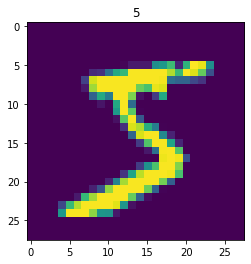

In [12]:
import matplotlib.pyplot as plt

image0 = np.array(train_set[0][0]).reshape([28, 28])
label0 = train_set[1][0]
plt.figure()
plt.imshow(image0)
plt.title(label0)
plt.show()

In [18]:
images, labels = train_set[0], train_set[1]
print('训练集数量：{}'.format(len(images)))
# 训练集图片数量
num_of_images = len(images)
# 根据序号读取数据
index_list = list(range(num_of_images))

BATCH_SIZE = 100

np.random.shuffle(index_list)

def data_generator():
    imgs_list = []
    labels_list = []
    for i in index_list:
        img = np.array(images[i]).astype('float32')
        label = np.array(labels[i]).astype('float32')
        imgs_list.append(img)
        labels_list.append(label)
        # 获得一个batch_size的数据则返回
        if len(imgs_list) == BATCH_SIZE:
            yield np.array(imgs_list), np.array(labels_list)
            # 清空列表
            imgs_list = []
            labels_list = []
            
    # 剩余数据不够一个batch_size,则直接返回
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    
    return data_generator

训练集数量：50000


In [20]:
def load_data(mode='train'):
    datafile = '../data/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
   
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    
    # 获得数据集长度
    imgs_length = len(imgs)
    
    # 定义数据集每个数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            # 训练模式下打乱数据
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据处理成希望的类型
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
    
        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [22]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是1
         self.fc = Linear(in_features=980, out_features=1)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层不使用激活函数
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x
    
    #网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置为0.01
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

    # 训练5轮
    EPOCH_NUM = 5
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28

    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            images = paddle.reshape(images, [images.shape[0],1,IMG_ROWS,IMG_COLS])
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')

#创建模型    
model = MNIST()
#启动训练过程
train(model)

D:\Path\Anaconda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading mnist dataset from ../data/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000


NameError: name 'random' is not defined